#   Derin Öğrenme Bootcamp Projesi : Intel Image Classification Veriseti ile

#  1) Kütüphanelerin Yüklenmesi ve Veri Setinin Tanımlanması


* TensorFlow, NumPy, Matplotlib gibi temel kütüphaneler yüklenmiştir.
* Kaggle ortamında bulunan **Intel Image Classification** veri setinin eğitim ve test dizinleri tanımlanmıştır.
* Veri setinin sınıfları yazdırılmıştır. Veri seti , 6 sınıftan oluşmaktadır: **Buildings, Forest, Glacier, Mountain, Sea, Street**.  


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam

train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'


print("=== Veri Seti Hakkında ===")

class_names = os.listdir(train_dir)
print(f"Sınıf sayısı: {len(class_names)}")
print("Sınıflar:", class_names)

=== Veri Seti Hakkında ===
Sınıf sayısı: 6
Sınıflar: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


# 2.1) Veri Ön İşleme 

Bu bölümde veri seti CNN modeline uygun hale getirilmiştir:
 
* **Normalize edilerek (0–1 aralığına)** piksel değerleri ölçeklendirildi.

* Modelin aşırı öğrenme yaşamaması için ve daha genelleyici hale gelmesi için eğitim verisi **Veri artırma**(Data augmentation) ile çeşitlendirildi. (Görseller döndürüldü,yatay ve dikey eksende kaydırıldı,yakınlaştırma uzaklaştırma yapıldı. )

* Tüm görüntüler 150x150 piksel boyutuna dönüştürüldü.

* Batch sze belirlendi. Model bir defada  32 resim işleyecek.Böylece daha yavaş da olsa iyi bir eğitim yapacak.
* Eğitim verisinin %20’si **validation seti** olarak ayrıldı.  
* Test verisi yalnızca normalize edilerek modele hazırlandı.  




In [37]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   validation_split=0.2)      

test_datagen = ImageDataGenerator(rescale=1./255)                             


train_generator = train_datagen.flow_from_directory(
    train_dir,                  
    target_size=(150, 150),      
    batch_size=32,                
    class_mode='categorical',     
    subset='training'           
)

# Validation verisini yükleyelim.

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'                                                
)

# Test verisini yükleyelim.

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False              
)

# 5. Yüklenen veriyi kontrol etme

print("=== VERİ SETİ BİLGİLERİ ===")
print(f"Sınıf isimleri: {list(train_generator.class_indices.keys())}")
print(f"Sınıf sayısı: {train_generator.num_classes}")
print(f"Eğitim örnek sayısı: {train_generator.samples}")
print(f"Validation örnek sayısı: {validation_generator.samples}")
print(f"Test örnek sayısı: {test_generator.samples}")


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
=== VERİ SETİ BİLGİLERİ ===
Sınıf isimleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Sınıf sayısı: 6
Eğitim örnek sayısı: 11230
Validation örnek sayısı: 2804
Test örnek sayısı: 3000


 # **2.2) Veri Görselleştirme**

* show_sample_images fonksiyonu, verilen veri üreticisinden (generator) bir batch resim ve etiket alıp  ilk 16 resmi göstermiştir. Her resmin üstünde sınıf adı yer almaktadır.
* Eğitim,validation,test olarak ayrılan verilerin ,sınıf dağılımları görselleştirilmiştir.

Eğitim verisinden örnekler:


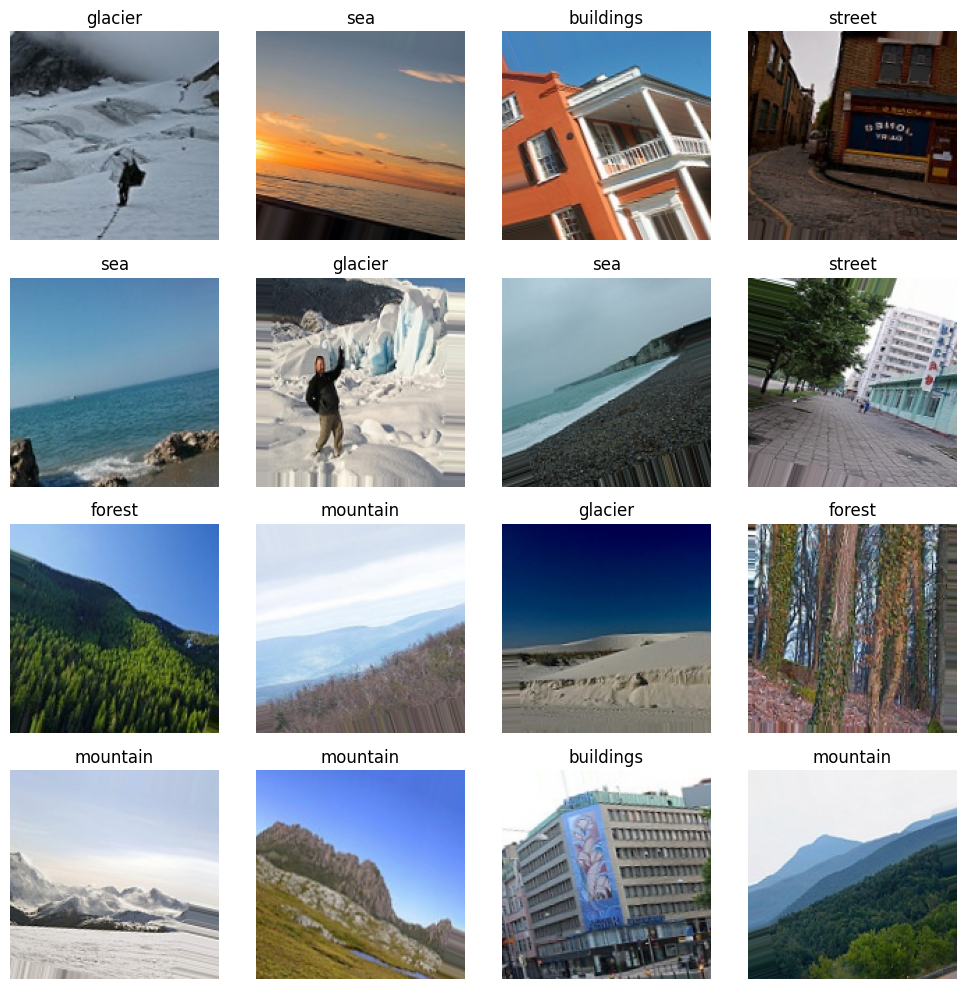

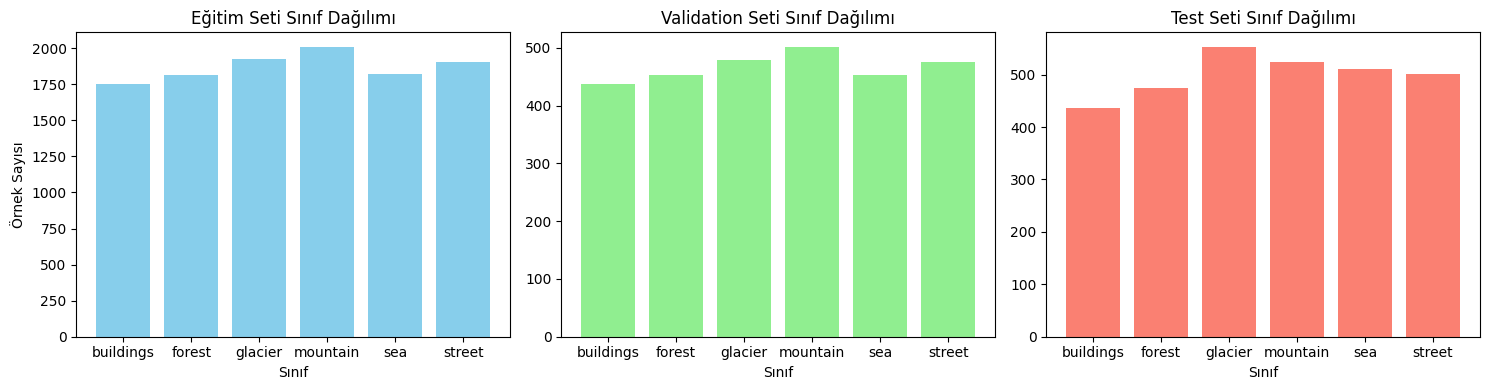

In [38]:
def show_sample_images(generator):
    images, labels = next(generator)                       
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(10,10))
    for i in range(16):                                     
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"{class_names[tf.argmax(labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Eğitim verisinden örnekler:")
show_sample_images(train_generator)

# Sınıf dağılımlarını görselleştirelim.

class_names = list(train_generator.class_indices.keys())

train_counts = train_generator.classes
val_counts   = validation_generator.classes
test_counts  = test_generator.classes

train_class_counts = [np.sum(train_counts == i) for i in range(len(class_names))]
val_class_counts   = [np.sum(val_counts == i)   for i in range(len(class_names))]
test_class_counts  = [np.sum(test_counts == i)  for i in range(len(class_names))]

fig, axes = plt.subplots(1, 3, figsize=(15,4))  


axes[0].bar(class_names, train_class_counts, color='skyblue')
axes[0].set_title('Eğitim Seti Sınıf Dağılımı')
axes[0].set_ylabel('Örnek Sayısı')
axes[0].set_xlabel('Sınıf')


axes[1].bar(class_names, val_class_counts, color='lightgreen')
axes[1].set_title('Validation Seti Sınıf Dağılımı')
axes[1].set_xlabel('Sınıf')


axes[2].bar(class_names, test_class_counts, color='salmon')
axes[2].set_title('Test Seti Sınıf Dağılımı')
axes[2].set_xlabel('Sınıf')

plt.tight_layout()  



* Verinin ; Eğitim , Validation , Test setlerine göre ayrılma oranları gösterilmiştir.

In [39]:
egitim = train_generator.samples
dogrulama = validation_generator.samples
test = test_generator.samples
toplam = egitim + dogrulama + test


egitim_yuzde = (egitim / toplam) * 100
dogrulama_yuzde = (dogrulama / toplam) * 100
test_yuzde = (test / toplam) * 100

print("Veri Dağılımı:")
print(f"Eğitim: {egitim} (%{egitim_yuzde:.1f})")
print(f"Doğrulama: {dogrulama} (%{dogrulama_yuzde:.1f})")
print(f"Test: {test} (%{test_yuzde:.1f})")

Veri Dağılımı:
Eğitim: 11230 (%65.9)
Doğrulama: 2804 (%16.5)
Test: 3000 (%17.6)


#  3) Modelin Eğitilmesi 

Model, CNN mimarisi kullanılarak tasarlanmıştır.

Modelin yapısı şöyledir:

* Conv2D + MaxPooling2D katmanları: Görüntülerden öznitelik çıkarmak için 3 adet evrişim ve havuzlama katmanı eklenmiştir. İlk katman 32 filtre ile başlamakta, ardından 64 ve 128 filtreler ile derinlik artırılmaktadır.  
* Dropout katmanları: Aşırı öğrenmeyi (overfitting) engellemek için %25 ve %50 oranında dropout uygulanmıştır.
* Flatten + Dense katmanları: Evrişim katmanlarından çıkan özellik haritaları düzleştirilmiş ve 256 nöronlu tam bağlı katmanla öğrenme yapılmıştır.  
* Çıkış katmanı 6 sınıf için softmax aktivasyonu kullanılarak olasılık dağılımı elde edilmiştir.  
* Model Compile ile Derleme: Model adam optimizer ve categorical_crossentropy kayıp fonksiyonu ile derlenmiştir.  
* Model fit ile Eğitim: Model, train_generator ile eğitilmiş ve validation_generator ile doğrulanmıştır (10 epoch).  

Bu sayede model, verilen eğitim görsellerinden öğrenerek yeni görselleri doğru sınıfa atamayı amaçlamaktadır.


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,998 (36.49 MB)

 Trainable params: 9,564,998 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 230ms/step - accuracy: 0.4420 - loss: 1.3814 - val_accuracy: 0.6316 - val_loss: 1.0140
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.6355 - loss: 0.9643 - val_accuracy: 0.6665 - val_loss: 0.8558
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.6652 - loss: 0.8836 - val_accuracy: 0.7065 - val_loss: 0.7872
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - accuracy: 0.6994 - loss: 0.7955 - val_accuracy: 0.7475 - val_loss: 0.7503
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.7211 - loss: 0.7522 - val_accuracy: 0.7561 - val_loss: 0.6563
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.7496 - loss: 0.6805 - val_accuracy: 0.7810 - val_loss: 0.6352
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - accuracy: 0.7539 - loss: 0.6706 - val_accuracy: 0.7871 - val_loss: 0.6183
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.7664 - loss: 0

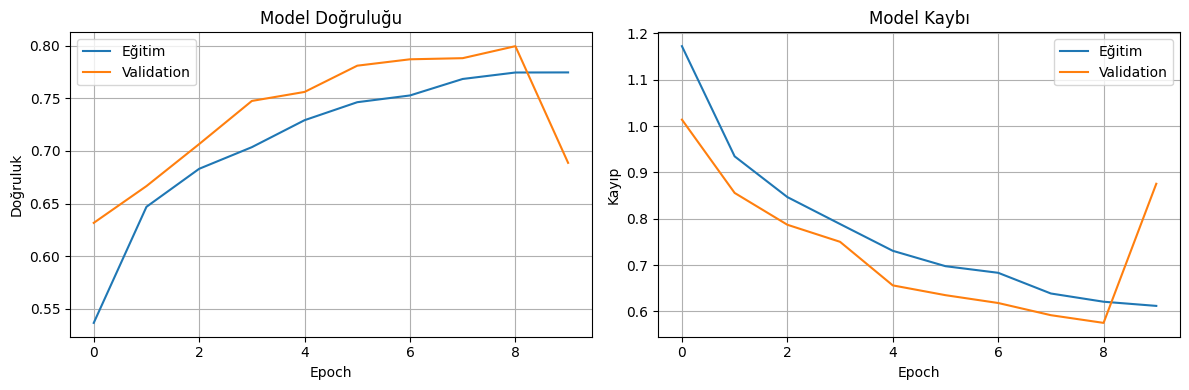

In [40]:
model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
        
# Tam bağlı katman
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer= Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)
plt.figure(figsize=(12, 4))  
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Eğitim') 
plt.plot(history.history['val_accuracy'], label='Validation') 
plt.title('Model Doğruluğu') 
plt.xlabel('Epoch')  
plt.ylabel('Doğruluk')  
plt.legend()  
plt.grid(True) 
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Eğitim') 
plt.plot(history.history['val_loss'], label='Validation')  
plt.title('Model Kaybı') 
plt.xlabel('Epoch') 
plt.ylabel('Kayıp') 
plt.legend()  
plt.grid(True) 
plt.tight_layout()  
plt.show()  


* Modelin, eğitim ve doğrulama (validation) sürecinde , kayıp (loss) değerlerinin epoch sayısına göre değişimi incelenmiştir.
*  Modelde, eğitim ve validation değerleri yakın sayılabilir.8. epochdan sonra validation doğrusunda düşüş yaşanması modelin ezberlemeye başlayacağını gösterebilir.Genel anlamda aşırı öğrenme vardır diyemeyiz.

# 4)Modelin Test Verisi ile Değerlendirilmesi

* Eğitilen modeli test verisi ile değerlendirilmiştir.
* Verilen görsellerin hangi sınıfa ait olduğunu ve ne oranda doğru tahmin edilebildiği incelenmiştir.


Test batch boyutu: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tahmin şekli: (32, 6)


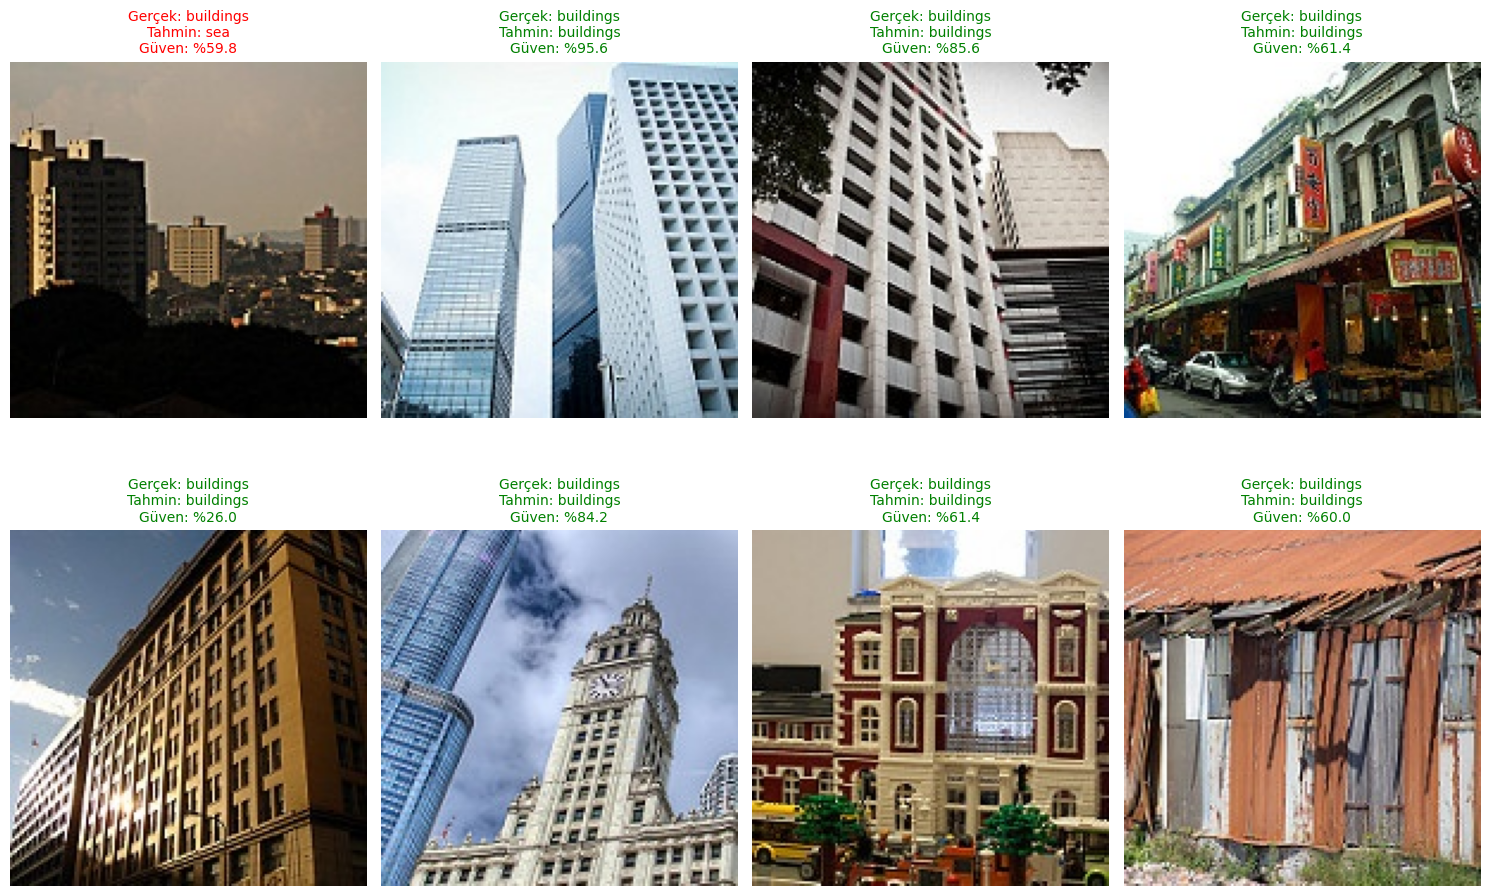

Tahmin Testi Sonuçları:
Toplam tahmin: 32
Doğru tahmin: 20
Yanlış tahmin: 12
Doğruluk: %62.50


In [60]:

test_images, test_labels = next(test_generator)
class_names = list(test_generator.class_indices.keys())

print(f"Test batch boyutu: {len(test_images)}")

# 2. Modelden tahmin al
predictions = model.predict(test_images)

# Tahminleri kontrol et
print(f"Tahmin şekli: {predictions.shape}")  


# 3. İlk 8 tahmini görselleştir
plt.figure(figsize=(15, 10))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_images[i])
    
# Gerçek ve tahmin edilen sınıflar
    true_class_idx = np.argmax(test_labels[i])
    pred_class_idx = np.argmax(predictions[i])
    
    true_class = class_names[true_class_idx]
    pred_class = class_names[pred_class_idx]
    confidence = np.max(predictions[i]) * 100  
    
    color = 'green' if true_class == pred_class else 'red'
    
    plt.title(f'Gerçek: {true_class}\nTahmin: {pred_class}\nGüven: %{confidence:.1f}', 
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

correct_predictions = 0
total_predictions = len(test_images)

for i in range(total_predictions):
    true_class_idx = np.argmax(test_labels[i])
    pred_class_idx = np.argmax(predictions[i])
    if true_class_idx == pred_class_idx:
        correct_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100

print("Tahmin Testi Sonuçları:")
print(f"Toplam tahmin: {total_predictions}")
print(f"Doğru tahmin: {correct_predictions}")
print(f"Yanlış tahmin: {total_predictions - correct_predictions}")
print(f"Doğruluk: %{accuracy:.2f}")



* Aşağıdaki kod satırında "Confusion Matrix" kullanılarak hangi sınıfların birbiriyle karıştırıldığı tespit edilmiştir.


 Model Değerlendirme:
Test Doğruluğu: %72.90
Confusion Matrix:
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step


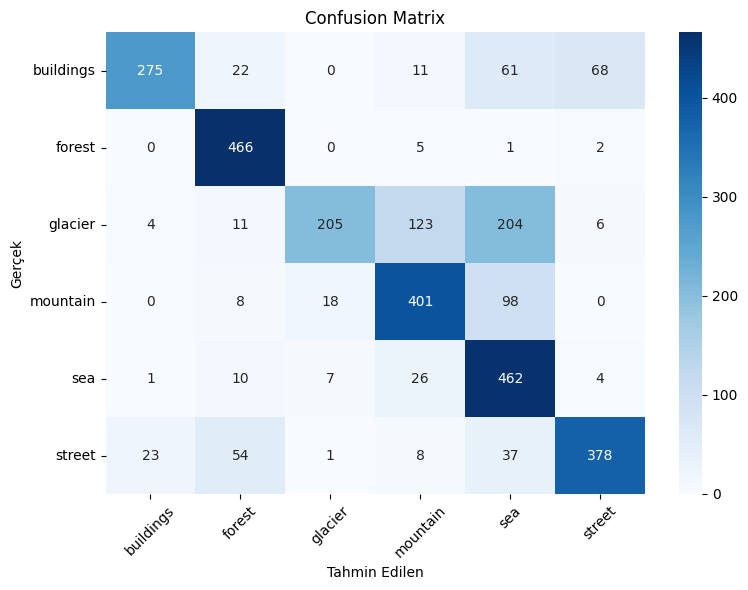

PERFORMANS ÖZETİ
📌 buildings: 275/437 (%62.9)
📌 forest: 466/474 (%98.3)
📌 glacier: 205/553 (%37.1)
📌 mountain: 401/525 (%76.4)
📌 sea: 462/510 (%90.6)
📌 street: 378/501 (%75.4)
En İyi Sınıf: forest (%98.3)
En Zor Sınıf: glacier (%37.1)
Genel Doğruluk: %72.90


In [56]:
print(" Model Değerlendirme:")

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Doğruluğu: %{test_accuracy*100:.2f}")

print("Confusion Matrix:")


# Tahminleri yapalım.

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion matrix oluştur

cm = confusion_matrix(y_true, y_pred_classes)

# Görselleştir

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. PERFORMANS ÖZETİ

print("PERFORMANS ÖZETİ")
print("=" * 40)

# Her sınıfın doğruluk oranı

class_accuracies = []
for i in range(len(class_names)):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = correct / total if total > 0 else 0
    class_accuracies.append(accuracy)
    print(f"📌 {class_names[i]}: {correct}/{total} (%{accuracy*100:.1f})")

# En iyi ve en kötü sınıf

best_class_idx = np.argmax(class_accuracies)
worst_class_idx = np.argmin(class_accuracies)

print(f"En İyi Sınıf: {class_names[best_class_idx]} (%{class_accuracies[best_class_idx]*100:.1f})")
print(f"En Zor Sınıf: {class_names[worst_class_idx]} (%{class_accuracies[worst_class_idx]*100:.1f})")
print(f"Genel Doğruluk: %{test_accuracy*100:.2f}")

# 5) Hiperparemetre Optimizasyonu 

 * Katman sayısını ,1 katman arttıralım .Daha derin bir öğrenme yapabilir.
 * Learning rate (öğrenme oranını )değiştirelim.Daha küçük öğrenme oranıyla model daha iyi öğrenecektir.

 


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 232ms/step - accuracy: 0.3990 - loss: 1.4326 - val_accuracy: 0.5553 - val_loss: 1.0796
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.6032 - loss: 1.0086 - val_accuracy: 0.6748 - val_loss: 0.8895
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.6508 - loss: 0.9183 - val_accuracy: 0.6723 - val_loss: 0.8065
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.6973 - loss: 0.8089 - val_accuracy: 0.7489 - val_loss: 0.7035
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.7372 - loss: 0.7394 - val_accuracy: 0.7361 - val_loss: 0.7050
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.7419 - loss: 0.6986 - val_accuracy: 0.7643 - val_loss: 0.6664
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - accuracy: 0.7715 - loss: 0.6497 - val_accuracy: 0.7482 - val_loss: 0.7128
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 230ms/step - accuracy: 0.7857 - loss: 0

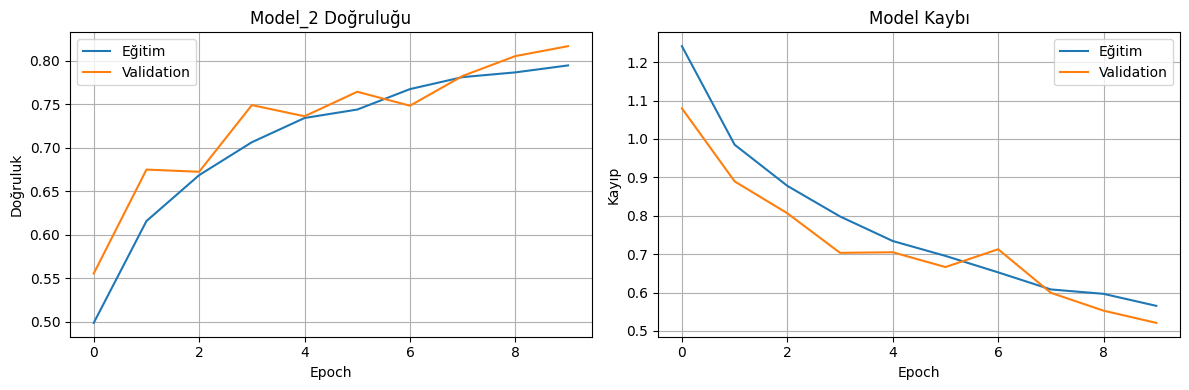

In [43]:
model_2 = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
#Eklenen Evrişim katmanı
        
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.5),   
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model_2.compile(optimizer= Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)
plt.figure(figsize=(12, 4))  
plt.subplot(1, 2, 1)  
plt.plot(history_2.history['accuracy'], label='Eğitim') 
plt.plot(history_2.history['val_accuracy'], label='Validation') 
plt.title('Model_2 Doğruluğu') 
plt.xlabel('Epoch')  
plt.ylabel('Doğruluk')  
plt.legend()  
plt.grid(True) 
plt.subplot(1, 2, 2)  
plt.plot(history_2.history['loss'], label='Eğitim') 
plt.plot(history_2.history['val_loss'], label='Validation')  
plt.title('Model Kaybı') 
plt.xlabel('Epoch') 
plt.ylabel('Kayıp') 
plt.legend()  
plt.grid(True) 
plt.tight_layout()  
plt.show()  

* Optimizasyon sonucunda ; Eğitim ile validation doğruları birbirine  yakınlaşmıştır ve validation genel manada artış göstermiştir.Bu da modelin öğrenmesinde,genellemesinde iyileşme sağlandığını gösterir.
* Modelde,validation doğrusunun 6.epoch dışında hep eğitim doğrusunun üzerinde olması modelin aşırı öğrenme durumunda olmadığını göstermiştir.
* Loss değerinde güzel bir düşüş yaşanmıştır.
* Model doğruluğu ise artış göstermiştir. 

## Modellerin Karşılaştırılması :

Hiperparemetre Optimizasyonu kapsamında:
* öğrenme oranındaki artış (0.001 den 0.0005 e yükseliş)
* Katman sayısını arttırmak (3 den 4 e arttırma)
sayesinde model doğruluğu artış göstermiştir.

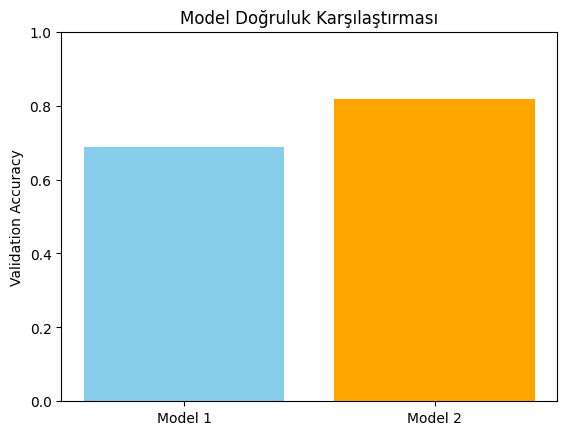

In [47]:
import matplotlib.pyplot as plt

# Doğru tanımlanmış history objeleri üzerinden doğruluk skorlarını çek
acc_model1 = history.history['val_accuracy'][-1]
acc_model2 = history_2.history['val_accuracy'][-1]

# Bar grafiği ile karşılaştır
plt.bar(['Model 1', 'Model 2'], [acc_model1, acc_model2], color=['skyblue', 'orange'])
plt.ylabel('Validation Accuracy')
plt.title('Model Doğruluk Karşılaştırması')
plt.ylim(0, 1)
plt.show()


In [53]:
print(" Model 1  Değerlendirme:")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Doğruluğu: %{test_accuracy*100:.2f}")

print(" Model 2  Değerlendirme:")
test_loss, test_accuracy = model_2.evaluate(test_generator, verbose=0)
print(f"Test Doğruluğu: %{test_accuracy*100:.2f}")

 Model 1  Değerlendirme:
Test Doğruluğu: %72.90
 Model 2  Değerlendirme:
Test Doğruluğu: %82.77
